# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle that contains information on 3 million used cars.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding
Rudy Russo has a problem. We've seen how bad business is. Thanks to Fuchs, his name is mud.

Something that may help Rudy is to accurately price used cars as appropriately priced cars tend to sell faster.

By leveraging existing data, we can build a supervised learning model using the sale price for predictions.

#####  The analysis will highlight factors influincing the price 
#####  The model will then identify the correlations that impact pricing
#####  A validated model can then be used to provide informed pricing on prospective vehicles.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Import tools for programming

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.experimental import enable_iterative_imputer
from sklearn import preprocessing
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

Load the dataset

In [170]:
rudy = pd.read_csv('data/vehicles.csv')

List columns, counts and data types

In [171]:
rudy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

Visualize data and headers within the table

In [172]:
rudy.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


Take a random sample of the table to glimpse at data distribution

In [173]:
rudy.sample(20)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
397242,7306937915,richmond,24990,2014.0,mitsubishi,fuso fe,good,4 cylinders,diesel,117851.0,clean,automatic,JL6CRK1A0EK003991,rwd,full-size,truck,white,va
230535,7310402775,asheville,32590,2017.0,infiniti,q50 red sport 400 sedan,good,NaN,other,25627.0,clean,other,JN1FV7AP1HM850517,rwd,NaN,sedan,red,nc
209588,7311349140,southwest michigan,53796,2019.0,chevrolet,silverado 1500,NaN,8 cylinders,gas,19171.0,clean,automatic,1GCUYHED8KZ366162,4wd,NaN,truck,blue,mi
41616,7316193610,orange county,0,2015.0,jeep,renegade sport,NaN,4 cylinders,gas,55157.0,clean,automatic,ZACCJAATXFPB38785,fwd,NaN,SUV,NaN,ca
46609,7313516146,redding,35000,2006.0,ram,2500,excellent,6 cylinders,diesel,145566.0,clean,automatic,NaN,4wd,full-size,pickup,silver,ca
300155,7307259605,lima / findlay,10259,2015.0,kia,forte,excellent,NaN,gas,58184.0,clean,automatic,KNAFZ5A33F5346915,fwd,NaN,hatchback,NaN,oh
107572,7314095813,pensacola,7495,2016.0,chevrolet,spark,NaN,4 cylinders,gas,48521.0,rebuilt,automatic,KL8CD6SA3GC649450,fwd,NaN,other,blue,fl
12189,7315853406,phoenix,26990,2015.0,audi,q7 3.0t s line prestige,good,6 cylinders,gas,75832.0,clean,automatic,WA1DGAFE4FD010449,NaN,NaN,other,black,az
352186,7309334813,chattanooga,17990,2015.0,ram,promaster city wagon slt,NaN,4 cylinders,gas,99480.0,clean,automatic,ZFBERFBT0F6953094,fwd,NaN,van,white,tn
391315,7306218655,fredericksburg,32590,2017.0,ford,mustang gt coupe 2d,good,NaN,other,20689.0,clean,other,1FA6P8CF9H5332494,rwd,NaN,coupe,silver,va


Describe the columns to look at the counts, averages and ranges of data within columns

In [174]:
rudy.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Drop the id and vin columns. They contain unique identifiers which are not needed for the model

In [175]:
rudy2 = rudy.drop(columns = ['id','VIN'], axis=1)
rudy2.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


Scrub the data to contain only lowercase and remove spaces

In [176]:
for column in rudy2.columns[1:]:
    if rudy2[column].dtype == 'object':
        rudy2[column] = rudy2[column].str.lower().str.strip()

In [177]:
rudy2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  drive         296313 non-null  object 
 12  size          120519 non-null  object 
 13  type          334022 non-null  object 
 14  paint_color   296677 non-null  object 
 15  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 52.1+ MB


Identify null values with columns

In [178]:
rudy2.isnull().sum()

region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

Fill null values with values derived from the column (impute). Two methods will be used to impute values, Extra trees regression for numarical data and Bayesian Ridge for catigorical data. To apply these methods, the data will be split by data type. Float columns are numerical and go the th eExtratreesregressor while object categories are categorical and go to the Baysesian Ridge.

In [179]:
imputers = [
    BayesianRidge(),
    ExtraTreesRegressor(n_estimators=10, random_state=0),]

Identify numerical and categorical columns, impute values and check for remaining null values.

In [180]:
floats = ['year', 'odometer']

object = list((Counter(rudy2.columns) -\
                    Counter(floats + ['manufacturer', 'model', 'price'])).elements())
sr_floats = rudy2[floats]
imp_floats = IterativeImputer(imputers[1])
imputed_vals = imp_floats.fit_transform(sr_floats)
rudy2[floats] = imputed_vals
rudy2.isnull().sum()[floats]

year        0
odometer    0
dtype: int64

In [181]:
def encode(data_col):
    vals = np.array(data_col.dropna())
    reshaped_data = vals.reshape(-1,1)
    encoded_data = encoder.fit_transform(reshaped_data)
    data_col.loc[data_col.notnull()] = np.squeeze(encoded_data)
    return data_col

sr_object = rudy2[object]
encoder = preprocessing.LabelEncoder()

for column in object:
    encode(sr_object[column])
    imp_categorical = IterativeImputer(BayesianRidge())
    imputed_vals_cat = imp_categorical.fit_transform(sr_object[column].values.reshape(-1, 1))
    imputed_vals_cat = imputed_vals_cat.astype('int64')
    imputed_vals_cat = pd.DataFrame(imputed_vals_cat)
    imputed_vals_cat = encoder.inverse_transform(imputed_vals_cat.values.reshape(-1, 1))
    sr_object[column] = imputed_vals_cat

rudy2[object]= sr_object
rudy2.isnull().sum()[object]

region          0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

Take a look at the table header and random sample

In [182]:
rudy2.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,prescott,6000,2014.0,NaN,NaN,fair,5 cylinders,gas,96737.302119,clean,automatic,4wd,full-size,pickup,grey,az
1,fayetteville,11900,2014.0,NaN,NaN,fair,5 cylinders,gas,96737.302119,clean,automatic,4wd,full-size,pickup,grey,ar
2,florida keys,21000,2014.0,NaN,NaN,fair,5 cylinders,gas,96737.302119,clean,automatic,4wd,full-size,pickup,grey,fl
3,worcester / central MA,1500,2014.0,NaN,NaN,fair,5 cylinders,gas,96737.302119,clean,automatic,4wd,full-size,pickup,grey,ma
4,greensboro,4900,2014.0,NaN,NaN,fair,5 cylinders,gas,96737.302119,clean,automatic,4wd,full-size,pickup,grey,nc


In [183]:
rudy2.sample(10)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
320380,medford-ashland,44995,2017.0,audi,a7,like new,6 cylinders,gas,14921.0,clean,automatic,4wd,mid-size,sedan,grey,or
417289,green bay,7950,2008.0,toyota,tundra,fair,8 cylinders,gas,247000.0,clean,automatic,4wd,full-size,pickup,black,wi
202528,grand rapids,6000,2011.0,volkswagen,cc,like new,4 cylinders,gas,142000.0,clean,automatic,4wd,full-size,other,silver,mi
166684,"kansas city, MO",3300,2008.0,hyundai,sonata,fair,5 cylinders,gas,201000.0,clean,automatic,4wd,full-size,pickup,grey,ks
370824,dallas / fort worth,5660,2010.0,kia,forte,fair,4 cylinders,gas,119850.0,clean,automatic,fwd,mid-size,sedan,custom,tx
375296,houston,18088,2018.0,toyota,c-hr,fair,4 cylinders,gas,65440.0,clean,automatic,fwd,full-size,sedan,white,tx
21488,bakersfield,42995,2016.0,ford,transit-350,fair,5 cylinders,gas,42141.0,clean,automatic,rwd,full-size,pickup,white,ca
80162,fort collins / north CO,28999,2014.0,ram,2500 slt,excellent,8 cylinders,gas,149790.0,clean,automatic,4wd,full-size,pickup,grey,co
344871,charleston,28990,2018.0,infiniti,qx60 3.5 sport utility,good,6 cylinders,gas,32458.0,clean,other,fwd,full-size,suv,black,sc
73344,colorado springs,27590,2018.0,toyota,rav4,fair,4 cylinders,gas,38360.0,clean,automatic,4wd,mid-size,suv,white,co


Since the price will be the main focus of the analysis, a glimpse of the top to prices will be helpful in understanding the distribution of prices.

In [184]:
price_counts = rudy2.price.value_counts()
print('Price: ', price_counts.index[0], '\nCounts: ', price_counts.values[0])
print('\nTen most frequently occurring prices:\n')
print(price_counts[:10])

Price:  0 
Counts:  32895

Ten most frequently occurring prices:

0        32895
6995      3169
7995      3129
9995      2867
8995      2837
4500      2778
5995      2727
3500      2716
29990     2705
6500      2594
Name: price, dtype: int64


In [185]:
rudy2.describe()

,price,year,odometer
count,4.268800e+05,426880.000000,4.268800e+05
mean,7.519903e+04,2011.246252,9.806397e+04
std,1.218228e+07,9.448533,2.128619e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2008.000000,3.800000e+04
50%,1.395000e+04,2013.000000,8.600000e+04
75%,2.648575e+04,2017.000000,1.335330e+05
max,3.736929e+09,2022.000000,1.000000e+07


A histogram will help visualize the price column and distribution

In [186]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(6,3)})

def plot_histogram(col, color_val='#005c9d',\
                   x_label='Price [x10\u2076 USD]', y_label='Frequency',\
                   title_text='Distribution of car prices'):
    sns.distplot(col, kde=False, color=color_val)
    
    ax = plt.gca()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title_text)
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)

    plt.show()

Some prices seem to be outlyers to the range. An histogram limiting the range to less than $75000 provides a better view.

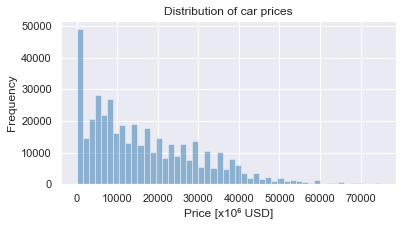

In [187]:
plot_histogram(rudy2.price[rudy2.price<75000])

Converting the price to a log of the price will shift the distibution more toward a normal distibution and possibly provide a better fit for the model. The log price is generated and added as a column.

In [188]:
rudy2.insert(1, 'logprice', np.log1p(rudy2['price']))

Log of the Price plotted in a histogram

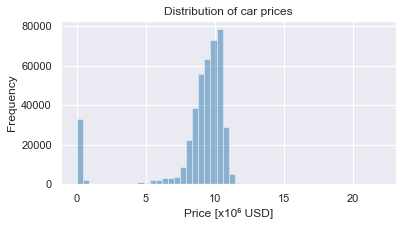

In [189]:
plot_histogram(rudy2.logprice)

The price column is limited to the difference between the upper and lower quartile. This is known as the interquartile range (IQR). Using the IQR, outliers at the low and high ranges of the dataset are removed, allowing for analysis to be based on the middle half of the distribution and less influenced by extreme values 

In [190]:
rudy2['price'] = rudy2.price.astype(str)
Q1 = rudy2.quantile(0.25)
Q3 = rudy2.quantile(0.75)
IQR = Q3 - Q1
rudy2 = rudy2[~((rudy2 < (Q1 - 1.5 * IQR)) | (rudy2 > (Q3 + 1.5 * IQR))).any(axis=1)]
rudy2['price'] = rudy2.price.astype(np.int64)

The model and manufacturer columns are cleaned up by dropping model names that appear less than 1000 times.  The model data is then used to fill in manufacturer null values by providing the most common manufacturer for that model.

In [191]:
rudy2 = rudy2.groupby("model").filter(lambda x: len(x) >= 1000)
rudy2.reset_index(drop=True, inplace=True)
rudy2['manufacturer'] = rudy2.groupby('model').manufacturer.transform(
    lambda x: x.fillna(x.mode()[0]))

The manufacturers are then visualized in a count plot

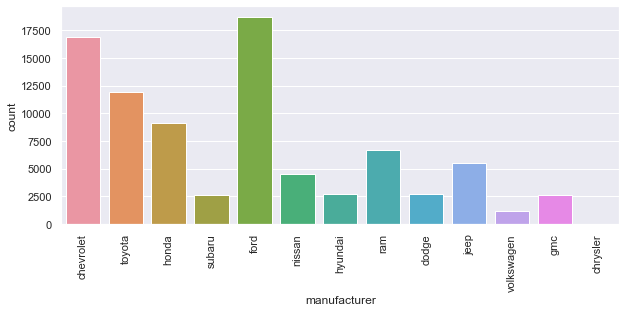

In [192]:
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)
sns.countplot(rudy2.manufacturer);

Correlations between numerical columns are explored

In [193]:
rudy2.corr()

,logprice,price,year,odometer
logprice,1.000000,0.882618,0.644341,-0.540663
price,0.882618,1.000000,0.581222,-0.522864
year,0.644341,0.581222,1.000000,-0.623530
odometer,-0.540663,-0.522864,-0.623530,1.000000


There is a positive correlation between price and year, implying that as year increases, the price increases. This makes sense since newer cars typically cost more and observed in the plot below.

<AxesSubplot:xlabel='year', ylabel='price'>

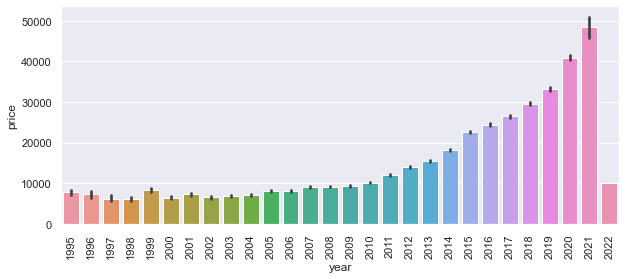

In [194]:
year = rudy2.year.astype(np.int64)
price = rudy2.price
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)
sns.barplot(year, price)

Now we can look at the distribution of categorical data through count plots

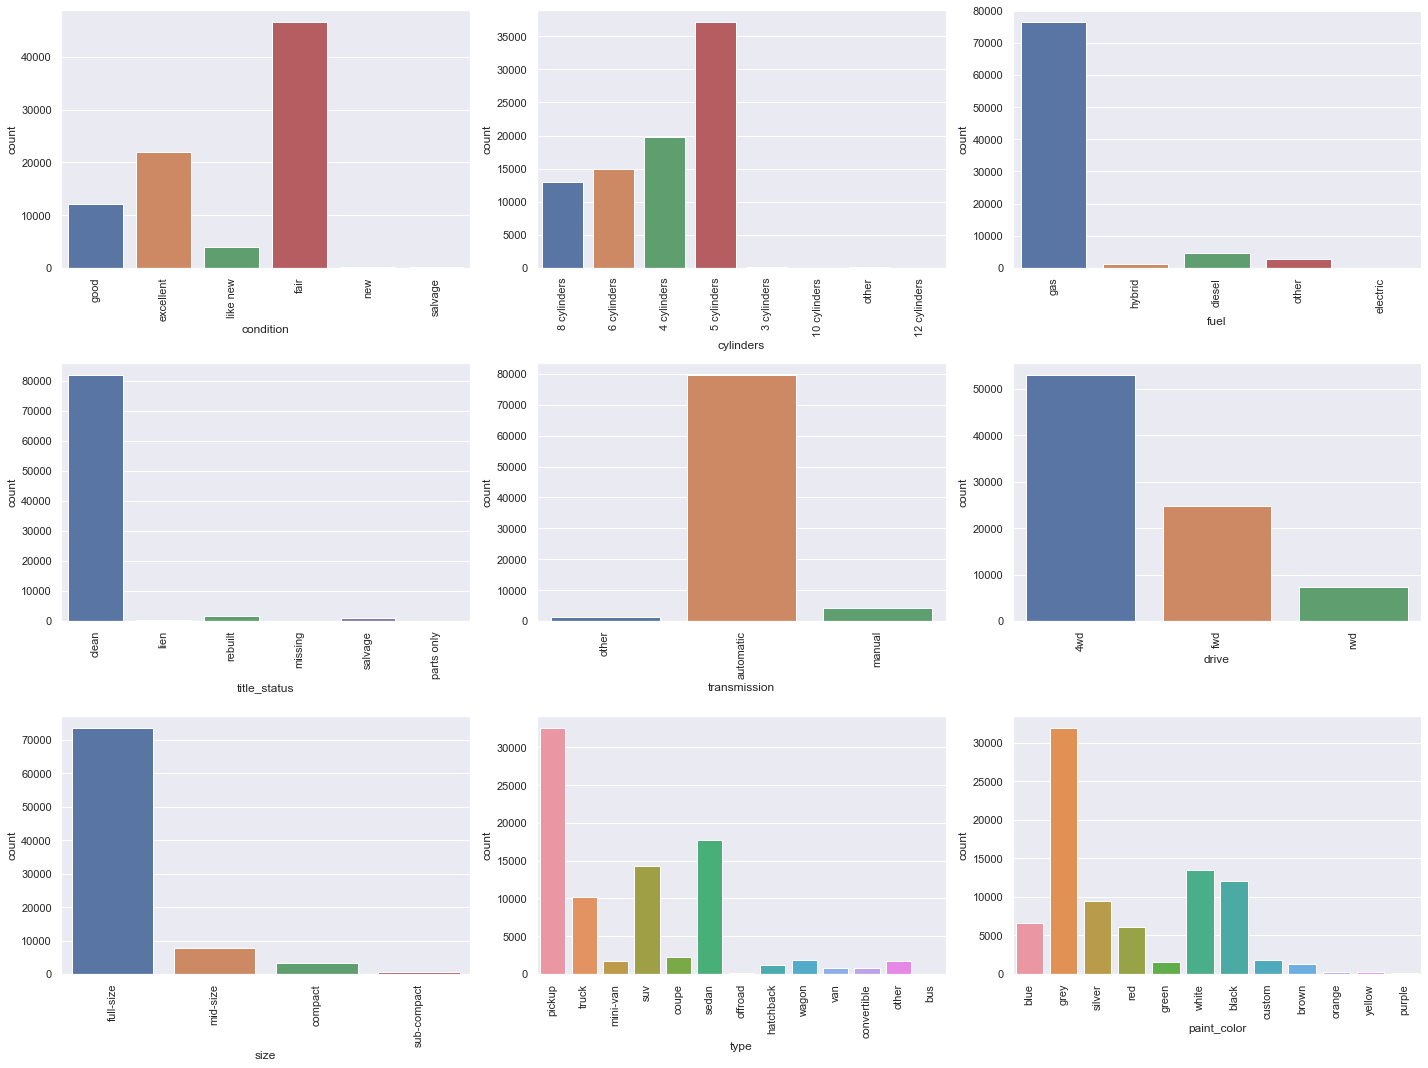

In [195]:
obplot = object.copy()
obplot.remove('region')
obplot.remove('state')

fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for variable, subplot in zip(obplot, ax.flatten()):
    sns.countplot(rudy2[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
plt.tight_layout()

And how the categorical data relates to price when plotted

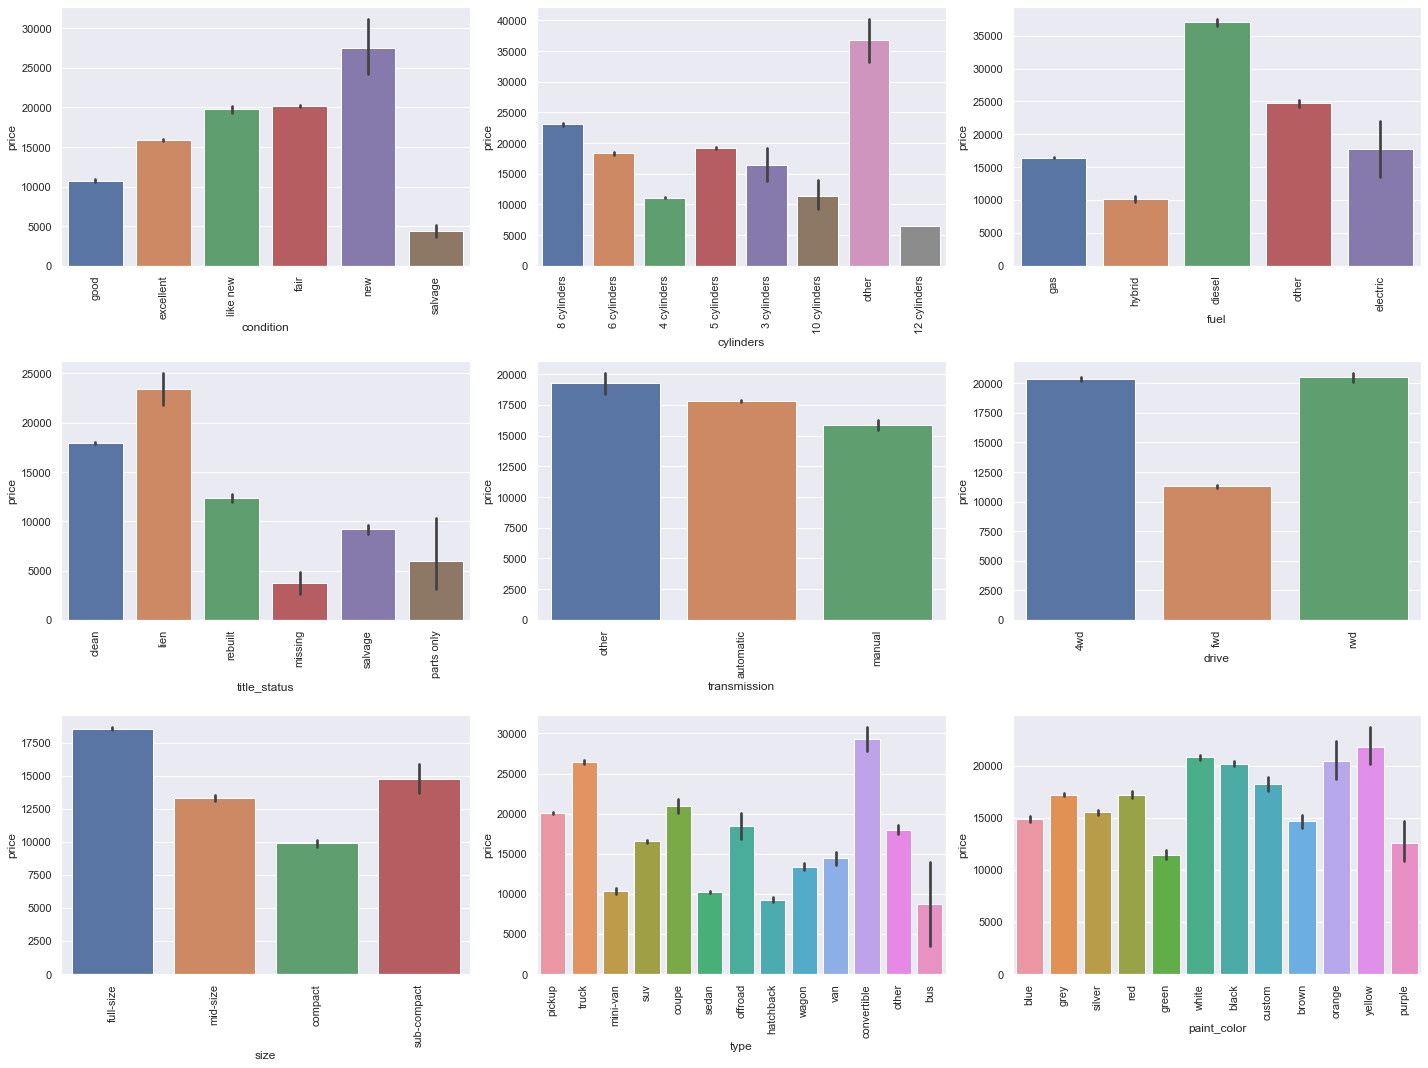

In [196]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for var, subplot in zip(obplot, ax.flatten()):
    sns.barplot(x=var, y='price', data=rudy2, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
plt.tight_layout()

As we proceed toward the modelling of the data, the "price" column can be dropped since the log price will be used.

In [197]:
rudy2.drop('price', axis=1, inplace=True)

In [198]:
col_list = ['logprice']
rearranged_cols = np.hstack((rudy2.columns.difference(col_list, sort=False), col_list))

rudy2 = rudy2.reindex(columns=rearranged_cols)

The numerical 

In [199]:
floats

['year', 'odometer']

and categorical columns are listed

In [200]:
object = list((Counter(rudy2.columns) -\
                    Counter(floats + ['logprice', 'price'])).elements())
object

['region',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

In [201]:
rudy2[object] = rudy2[object].apply(encoder.fit_transform)

And the dataframe is checked again

In [202]:
rudy2.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,logprice
0,16,2010.0,0,39,2,6,2,71229.0,0,2,0,1,7,1,1,10.025307
1,16,2019.0,11,42,0,5,2,43000.0,0,0,0,1,10,5,1,10.463132
2,16,2012.0,5,28,0,5,2,95000.0,0,0,1,1,4,9,1,9.546884
3,16,2017.0,10,20,3,3,2,22700.0,1,0,0,1,9,8,1,9.852247
4,29,2011.0,11,42,2,3,2,151060.0,0,0,2,1,10,9,1,9.543306


The categorical data is transformed into numerical data to be used in the model

In [203]:
columns_to_scale = floats + ['model']

In [204]:
scaler = StandardScaler()

for col in columns_to_scale:
   rudy2[col] = scaler.fit_transform(np.array(rudy2[col]).reshape(-1,1))

The IQR of the log price is updated in the table

In [205]:
Q1 = rudy2.logprice.quantile(0.25)
Q3 = rudy2.logprice.quantile(0.75)
IQR = Q3 - Q1

rudy3 = rudy2[(rudy2.logprice >= (Q1 - 1.5 * IQR)) & (rudy2.logprice <= (Q3 + 1.5 * IQR))]

Here is a sample of the table

In [206]:
rudy3.sample(5)

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,logprice
35670,94,-1.500770,5,0.463776,1,4,2,0.407010,0,0,0,1,7,5,20,7.937732
9365,294,0.188184,8,0.822151,0,3,2,0.296846,0,0,0,0,9,10,4,8.962007
28516,321,0.938830,10,0.535451,1,4,2,-1.342325,0,0,0,1,7,10,15,10.060320
69073,54,1.501814,0,1.252201,1,4,2,-1.237033,0,0,0,1,7,5,42,10.592903
33424,198,0.563507,8,-1.256425,2,3,2,0.736440,0,0,1,1,8,0,17,9.209940


A look at the plot of year and log price

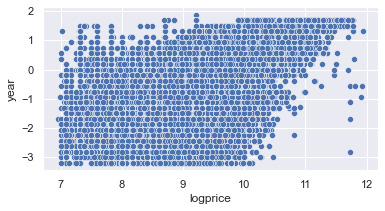

In [207]:
rudy_plot1 = sns.scatterplot(data=rudy3, x="logprice", y="year")

And a look at the scatter plot of the odometer and price

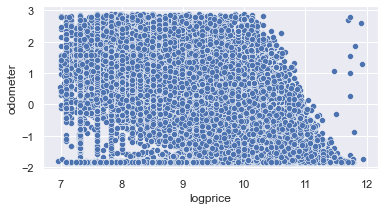

In [208]:
rudy_plot2 = sns.scatterplot(data=rudy3, x="logprice", y="odometer")

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

The data is then split inot training and test sets in the model

In [209]:
X = rudy3.iloc[:, :-1]
y = rudy3.iloc[:,-1:].values.T[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=22)
X,y

(       region      year  manufacturer     model  condition  cylinders  fuel  \
 0          16 -0.374801             0  1.252201          2          6     2   
 1          16  1.314152            11  1.467226          0          5     2   
 2          16  0.000522             5  0.463776          0          5     2   
 3          16  0.938830            10 -0.109624          3          3     2   
 4          29 -0.187139            11  1.467226          2          3     2   
 ...       ...       ...           ...       ...        ...        ...   ...   
 85010     397  0.375845             4  1.037176          2          6     2   
 85012     397 -1.313108             5 -1.041400          1          4     2   
 85013     397  0.188184             6 -0.611350          1          4     2   
 85014     397 -0.187139             5 -1.041400          1          4     2   
 85015     397 -1.313108             8 -1.256425          1          4     2   
 
        odometer  title_status  transm

A function to remove negative values

In [210]:
def remove_negatives(y_test, y_pred):
    ind = [index for index in range(len(y_pred)) if(y_pred[index]>0)]
    y_pred = y_pred[ind]
    y_test = y_test[ind]
    return (y_test, y_pred)   

And a function to measure the metrics of the model are added

In [211]:
def evaluate_perf(y_test, y_pred):
    res = []
    res.append(mean_squared_log_error(y_test, y_pred))
    res.append(np.sqrt(res[0]))
    res.append(r2_score(y_test, y_pred))
    res.append(round(r2_score(y_test, y_pred)*100, 4))
    return (res)

In [212]:
Rudy_metrics = pd.DataFrame(index=['MSLE', 'RMSLE','R2 score','Accuracy(%)'])

A baseline look at the training and test datasets

In [213]:
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_test = np.ones(shape = y_test.shape)*y_test.mean()
mse_baseline_train = mean_squared_error(baseline_train, y_train)
mse_baseline_test = mean_squared_error(baseline_test, y_test)
print(baseline_train.shape, baseline_test.shape)
print(f'Baseline for training data: {mse_baseline_train}')
print(f'Baseline for testing data: {mse_baseline_test}')

(58953,) (25266,)
Baseline for training data: 0.6848297240735784
Baseline for testing data: 0.6821199475184228


Now the data is fit to a linear regression model

In [214]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

And a check of the validation

In [215]:
y_test_1, y_pred_1 = remove_negatives(y_test, y_pred)
res_lin_reg = evaluate_perf(y_test_1, y_pred_1)

print("Coefficients: \n", lin_reg.coef_)
print(f"MSLE : {res_lin_reg[0]}")
print(f"Root MSLE : {res_lin_reg[1]}")
print(f"R2 Score : {res_lin_reg[2]} or {res_lin_reg[3]}%")

Rudy_metrics["Linear"] = res_lin_reg

Coefficients: 
 [-2.62617072e-05  4.46739617e-01  3.94306509e-03  7.71522925e-02
 -4.35403027e-02  2.26711415e-01 -2.15423610e-01 -2.17231899e-01
 -9.13854621e-02  9.75262864e-02 -1.31786915e-01 -4.51311211e-03
 -1.77554520e-02  3.88586067e-03 -1.19792128e-03]
MSLE : 0.00247535610178701
Root MSLE : 0.049752950684225854
R2 Score : 0.6271992205316707 or 62.7199%


A plot of the actual ve predicted values

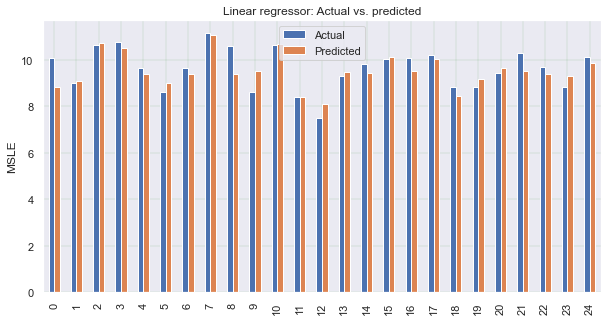

In [216]:
df_lin_comp = pd.DataFrame({'Actual': y_test_1, 'Predicted': y_pred_1})
df_lin_comp = df_lin_comp.head(25)

df_lin_comp.plot(kind='bar', figsize=(10,5))

plt.grid(which='major', linestyle='-', linewidth='0.1', color='green')
plt.title('Linear regressor: Actual vs. predicted')
plt.ylabel('MSLE')
plt.show()

And a look at the coefficients ranked by importance.  Year and cylinders are sensitive parameters in this model and may be carried over for refinement. Overall though, the linear regression model does not look very good

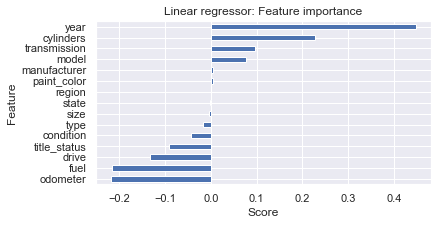

In [217]:
coefs = pd.Series(lin_reg.coef_, index = X_train.columns)
sorted_coefs = coefs.sort_values()

sorted_coefs.plot(kind = "barh")

plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.xlabel('Score'); 
plt.ylabel('Feature'); 
plt.title('Linear regressor: Feature importance')

plt.show()

The next model is the random forest model

In [231]:
X = rudy3.iloc[:, :-1]
y = rudy3.iloc[:,-1:].values.T[0]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=22)
X,y
rando_reg = RandomForestRegressor(n_estimators=180,
                               random_state=42,
                               min_samples_leaf=10,
                               max_features=0.5,
                               n_jobs=-1,
                               oob_score=True)
rando_reg.fit(X_train2,y_train2)
y_pred2 = rando_reg.predict(X_test2)

In [232]:

y_test_2, y_pred_2 = remove_negatives(y_test2, y_pred2)
res_rf_reg = evaluate_perf(y_test_2, y_pred_2)

print(f"MSLE : {res_rf_reg[0]}")
print(f"Root MSLE : {res_rf_reg[1]}")
print(f"R2 Score : {res_rf_reg[2]} or {res_rf_reg[3]}%")

Rudy_metrics['RandomForest'] = res_rf_reg

MSLE : 0.0008414782809629481
Root MSLE : 0.02900824505141509
R2 Score : 0.8809978789459133 or 88.0998%


Bar plots and the stats looking at the maximum likelihood sequence estimation, but there is improvement required. 

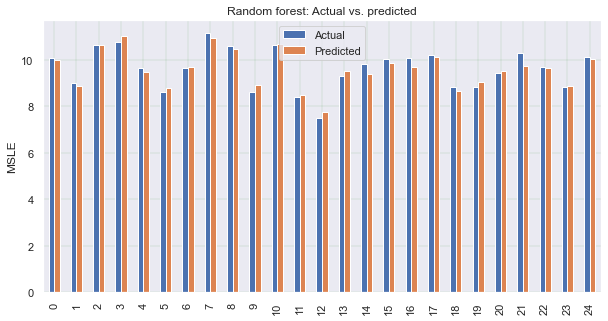

In [233]:
df_rf_comp = pd.DataFrame({'Actual': y_test_2, 'Predicted': y_pred_2})
df_rf_comp = df_rf_comp.head(25)

df_rf_comp.plot(kind='bar', figsize=(10,5))

plt.grid(which='major', linestyle='-', linewidth='0.1', color='green')
plt.title('Random forest: Actual vs. predicted')
plt.ylabel('MSLE')

plt.show()

Ridge analysis of the dataset. Not much improvement.

In [234]:
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)
print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')
ridge_pipe

Train MSE: 0.25431137917979124
Test MSE: 0.25429466722010674


Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

In [236]:
X = rudy3.iloc[:, :-1]
y = rudy3.iloc[:,-1:].values.T[0]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=22)
X,y
ridge_pipe.fit(X_train3,y_train3)
y_pred3 = ridge_pipe.predict(X_test3)
y_test_3, y_pred_3 = remove_negatives(y_test3, y_pred3)
res_ridge_reg = evaluate_perf(y_test_3, y_pred_3)

print(f"MSLE : {res_ridge_reg[0]}")
print(f"Root MSLE : {res_ridge_reg[1]}")
print(f"R2 Score : {res_ridge_reg[2]} or {res_ridge_reg[3]}%")

Rudy_metrics['Ridge'] = res_ridge_reg

MSLE : 0.00247535502320881
Root MSLE : 0.04975293984488565
R2 Score : 0.6271992471482511 or 62.7199%


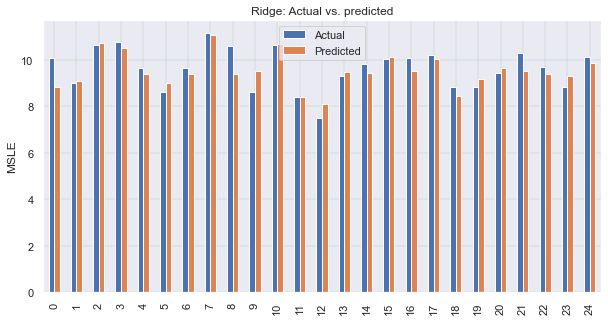

In [237]:
df_ridge_comp = pd.DataFrame({'Actual': y_test_3, 'Predicted': y_pred_3})
df_ridge_comp = df_ridge_comp.head(25)

df_ridge_comp.plot(kind='bar', figsize=(10,5))

plt.grid(which='major', linestyle='-', linewidth='0.1', color='green')
plt.title('Ridge: Actual vs. predicted')
plt.ylabel('MSLE')

plt.show()

### Evaluation

The dataset can support building a model. 

The current dataset is limited by inconsistancies in the variables.

Correlations have been identified to predict price but the data treatment and fitting require further investigation.

An approriate data cleaning process that identifies relevant factors and the fit to a strong model can be identified. Linear regression fits with approx. 62% accuracy.  The random forest model is an improvemnt over the linear regression model with a fit of 88%.

Alternate methods of analysis using k-nearest neighbors, cluster analysis, primary component analysis or polynomial fitting can be used and may provide stonger models.

### Deployment

The factors that are involved in pricing (car age, milage, and size) are intuitive pieces of the price. The subltety of their influence, however, is not easily discerned. As demonstrated by the models, a correlation and fit can be derived from the relationship of the price these factors. The best fitting models have a fit of 88%. Additional investigation into why the correlations exist and how they can be applied to beat the "human gut feeling" is warranted.